# This notebook will:
- compare beersheba between downsampled 5mm and normal 5mm
- compare speed of 5mm against 1mm and 2mm downsamples (you need to create this)


### imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tables as tb
from matplotlib import colors 

from typing          import Optional
from typing          import Union
from typing          import Callable

import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'


from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from IC.invisible_cities.cities.components import track_blob_info_creator_extractor
from IC.invisible_cities.io.hits_io        import load_hits
from IC.invisible_cities.io.hits_io        import hits_from_df
from IC.invisible_cities.core              import system_of_units as units
from IC.invisible_cities.types.symbols     import HitEnergy
from IC.invisible_cities.evm.event_model   import HitCollection
from IC.invisible_cities.evm.event_model   import Cluster
from IC.invisible_cities.evm.event_model   import Hit
from IC.invisible_cities.types.ic_types    import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

pd.set_option('display.max_rows', 200)

#import imageio

#import functions as func


### functions

In [ ]:
def plot_voxels(df, base_vsize = 12):

    xs = df.X
    ys = df.Y
    zs = df.Z
    es = df.E

    the_hits = []
    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)
    
    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)
    
    vsizex = voxels[0].size[0]
    vsizey = voxels[0].size[1]
    vsizez = voxels[0].size[2]

    min_corner_x = min(v.X for v in voxels) - vsizex/2.
    min_corner_y = min(v.Y for v in voxels) - vsizey/2.
    min_corner_z = min(v.Z for v in voxels) - vsizez/2.

    
    x = [np.round(v.X/vsizex) for v in voxels]
    y = [np.round(v.Y/vsizey) for v in voxels]
    z = [np.round(v.Z/vsizez) for v in voxels]
    e = [v.E for v in voxels]

    x_min = int(min(x))
    y_min = int(min(y))
    z_min = int(min(z))

    x_max = int(max(x))
    y_max = int(max(y))
    z_max = int(max(z))

    VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
    #print(VOXELS.shape)

    # sort through the event set the "turn on" the hit voxels
    cmap = cm.viridis
    norm = Normalize(vmin=0, vmax=max(e))

    colors = np.empty(VOXELS.shape, dtype=object)
    for q in range(0,len(z)):
        VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
        colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

    # and plot everything
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    #a,b,c is spacing in mm needs an extra dim
    a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
    a = a*vsizex + min_corner_x
    b = b*vsizey + min_corner_y
    c = c*vsizez + min_corner_z

    # a, b, c are the corners of the voxels
    ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

    ax.set_xlabel('x (mm)')#,fontsize=16)
    ax.set_ylabel('y (mm)')#,fontsize=16)
    ax.set_zlabel('z (mm)')#,fontsize=16)


    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm)
    cb.set_label('Energy (keV)')

    fig.suptitle('voxelised')

    #ax.view_init(-160, 90)

    plt.show(fig)

def plotter(df, evt, cut_n_drop = True):
    evt_interest = df[df.event == evt]
    
    print('======================')
    print(f'EVENT {evt}')
    print(f'Total energy {evt_interest.Ec.sum():.2f} MeV')
    print('======================\n')
    if cut_n_drop == True:
        hits_cut = coref.timefunc(cut_sensors)(evt_interest.copy())
        hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
    else:
        hits_drop = evt_interest
    pitch = 15.55
    # then applying transformations to convert to 'SiPM outputs'
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))


    xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
    yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
    zz = hits_cut.Z.unique()

    axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');

    fig.suptitle('Processed Sensors Signal_' + str(evt) + ' - rebin = 4', fontsize=30)
    #plt.savefig(f'plots/hits_{evt}.pdf')
    plt.show(fig)

def plotter_3d(evt_interest, evt):
    '''
    evt_interest - df
    evt          - event number

    '''
    # plot
    hits_cut = coref.timefunc(cut_sensors)(evt_interest.copy())
    hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
    
    xt = hits_drop.X
    yt = hits_drop.Y
    zt = hits_drop.Z
    et = hits_drop.E
    
    fig = plt.figure()
    #fig.suptitle('3D post deconvolution ' + str(evt), fontsize=30)
    fig.suptitle(f'Electron candidate event {evt}', fontsize=30)
    ax = fig.add_subplot(111, projection='3d')
    
    
    
    ets = et > 0 # eliminate small things for measurement
    
    #p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
    #plt_sphere([(-track.blob2_x.values[0], -track.blob2_y.values[0], -track.blob2_z.values[0])], [blobR])
    p = ax.scatter([xt[ets]], yt[ets], zt[ets], c=et[ets], alpha=0.65, cmap='viridis', s = 30)#, s = et[ets])
    #q = ax.scatter(xt, yt, zt, alpha = 0.3, color = 'red')
    
    # overlay the blobs and their radii
    
    cb = fig.colorbar(p, ax=ax)
    cb.set_label('Energy (keV)')
    
    
    ax.set_xlabel('\nx (mm)')
    ax.set_ylabel('\ny (mm)')
    ax.set_zlabel('\nz (mm)')
    
    #ax.set_xlim([-300, -100])
    #ax.set_ylim([250, 450])
    #ax.set_zlim([1600, 1800])
    #ax.view_init(20, -150)
    
    #plt.savefig(f'gif_making/deconv/angle_{i}.png')
    #plt.savefig(f'plots/hits_3d_{evt}.pdf')
    plt.show()

    return hits_drop


# Lets select a nice sample event

In [17]:
# set these once and forget
onemm_PSF_PATH = '/gluster/data/next/files/TOPOLOGY_John/N100_data/14914/prod_psf/eutropia/merged_psfs/final_psf.psf'
fivemm_PSF_PATH = '/gluster/data/next/files/TOPOLOGY_John/N100_data/14914/prod_psf/eutropia/merged_psfs/5mm/final_psf_5mm.psf'
fiveDS_PSF_PATH = '/gluster/data/next/files/TOPOLOGY_John/N100_data/14914/prod_psf/eutropia/merged_psfs/downsampled_psf_5mm.psf'
twoDS_PSF_PATH = '/gluster/data/next/files/TOPOLOGY_John/N100_data/14914/prod_psf/eutropia/merged_psfs/downsampled_psf_2point5mm.psf'
datatype = 'data'
detector_db = '/gluster/data/next/software/IC_311024/IC/invisible_cities/database/localdb.NEXT100DB.sqlite3'
run_number = 15107

In [18]:
def gen_deconv_params(psf_path, binning):
    
    return dict(
    q_cut           = 10, #5 for 6mm  - 5 for 6mm
    drop_dist       = [16, 16],
    psf_fname       = psf_path,     
    e_cut           = 0.2, #15 for 6mm  - 15 for 6mm
    n_iterations    = 20, #150 for 6mm  - 150 for 6mm
    iteration_tol   = 1e-9,
    sample_width    = [15.55, 15.55],
    bin_size        = [ binning,  binning],
    diffusion       = (1., 0.2),
    n_dim           = 2,
    deconv_mode     = DeconvolutionMode.joint,
    satellite_params = dict(satellite_start_iter = 100,
                            satellite_max_size   = 25,
                            e_cut                = 0.9,
                            cut_type             = CutType.rel),
    energy_type     = HitEnergy.Ec,
    cut_type        = CutType.rel)
    # inter_method    = InterpolationMethod.cubic)
    #satellite_params = dict(satellite_start_iter = 75,
    #                        satellite_max_size   = 3,
    #                        e_cut                = 0.2,
    #                        cut_type             = CutType.rel)

deconv_params_1mm = gen_deconv_params(onemm_PSF_PATH, 1)
deconv_params_1mm_   = {k : v for k, v in deconv_params_1mm.items() if k not in ['q_cut', 'drop_dist']}

deconv_params_5mm = gen_deconv_params(fivemm_PSF_PATH, 5)
deconv_params_5mm_   = {k : v for k, v in deconv_params_5mm.items() if k not in ['q_cut', 'drop_dist']}

deconv_params_5DS = gen_deconv_params(fiveDS_PSF_PATH, 5)
deconv_params_5DS_   = {k : v for k, v in deconv_params_5DS.items() if k not in ['q_cut', 'drop_dist']}

deconv_params_2DS = gen_deconv_params(twoDS_PSF_PATH, 2.5)
deconv_params_2DS_   = {k : v for k, v in deconv_params_2DS.items() if k not in ['q_cut', 'drop_dist']}


# Couple of functions used in beersheba. and we dont care which params they come from
cut_sensors       = beerfun.cut_over_Q   (deconv_params_1mm['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params_1mm['drop_dist'], ['E', 'Ec'])


# Now lets select a nice easy event at the photopeak

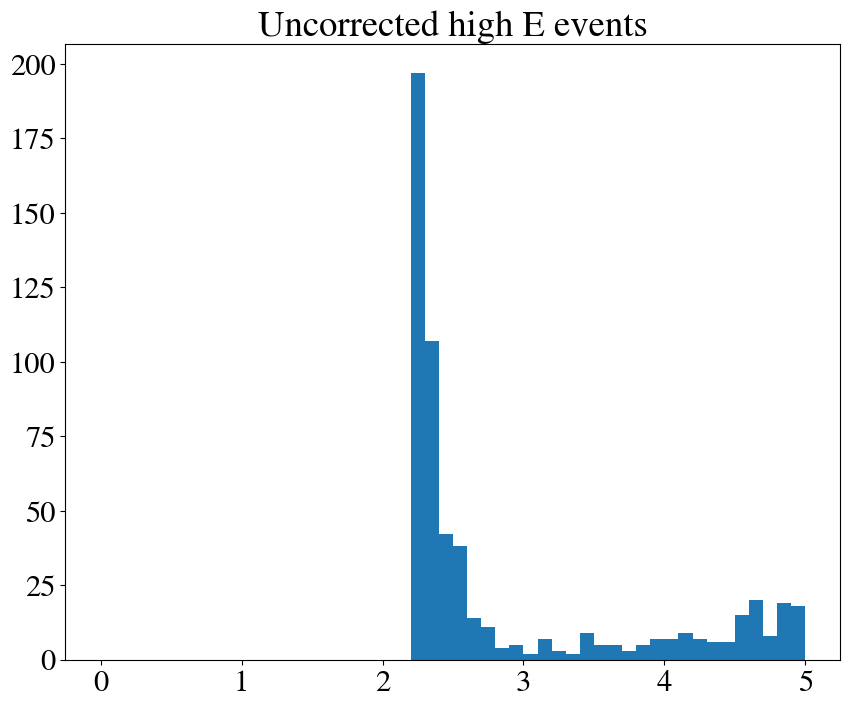

In [19]:
soph_file = 'files/15107_energy_split/corr_post_CE.h5'
post_CE = pd.read_hdf(soph_file, key = 'RECO/Events')

plt.hist(post_CE.groupby('event').Ec.sum(), bins = 50, range = [0, 5])
plt.title('Uncorrected high E events')
plt.show()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3348115,654754,1.742944e+09,0,52.969134,-93.402153,1,-451.525,-93.675,0.0,0.0,569.117375,5.034449,22.698537,-1.0,0.000144,-1,-1.0
3348116,654754,1.742944e+09,0,52.969134,-93.402153,1,-451.525,-32.475,0.0,0.0,569.117375,5.555621,25.048314,-1.0,0.000157,-1,-1.0
3348117,654754,1.742944e+09,0,52.969134,-93.402153,1,-65.775,-278.775,0.0,0.0,569.117375,6.461748,29.133719,-1.0,0.000148,-1,-1.0
3348118,654754,1.742944e+09,0,52.969134,-93.402153,1,351.075,-185.975,0.0,0.0,569.117375,5.291257,23.856392,-1.0,0.000130,-1,-1.0
3348119,654754,1.742944e+09,0,52.969134,-93.402153,1,-34.675,-202.025,0.0,0.0,572.565625,5.184258,101.972949,-1.0,0.000497,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3351243,654754,1.742944e+09,0,52.969134,-93.402153,1,335.525,415.475,0.0,0.0,759.797500,6.233183,8.771492,-1.0,NaN,-1,-1.0
3351244,654754,1.742944e+09,0,52.969134,-93.402153,1,-281.475,-62.575,0.0,0.0,763.822125,5.054821,15.384213,-1.0,0.000077,-1,-1.0
3351245,654754,1.742944e+09,0,52.969134,-93.402153,1,-297.025,29.725,0.0,0.0,763.822125,5.051856,15.375189,-1.0,0.000077,-1,-1.0
3351246,654754,1.742944e+09,0,52.969134,-93.402153,1,-50.225,230.375,0.0,0.0,767.494500,5.031432,-2.117011,-1.0,-0.000010,-1,-1.0


EVENT 654754
Total energy 2.40 MeV

Time spent in cut_over_Q: 0.02760148048400879 s
Time spent in drop_isolated: 0.0931386947631836 s


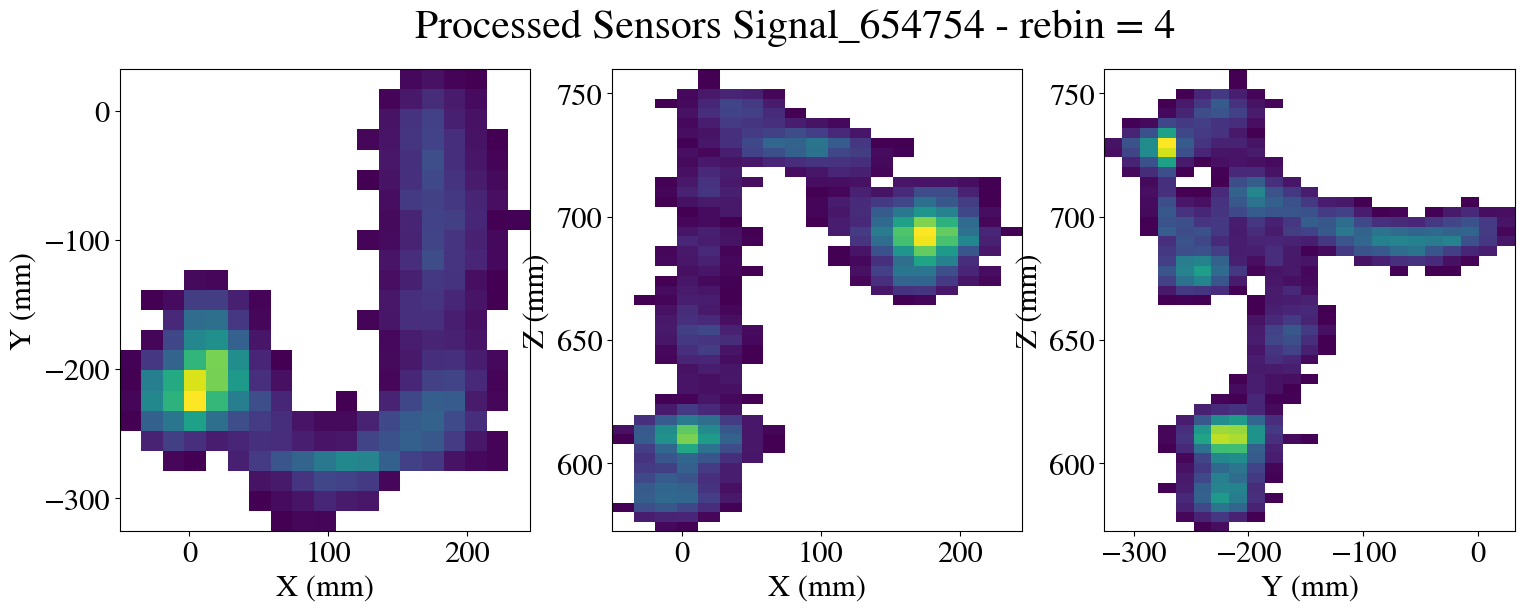

In [20]:
# select event that we know is decent
evt = 654754
evt_interest = post_CE[post_CE.event == evt]
display(evt_interest)
plotter(post_CE, evt)

In [21]:
#cut and drop
hits_cut = coref.timefunc(cut_sensors)(evt_interest.copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in cut_over_Q: 0.02990245819091797 s
Time spent in drop_isolated: 0.09748625755310059 s


In [9]:
deconvolver_1mm = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_1mm_)
print(f"{deconv_params_1mm['n_iterations']} iterations")
hits_deco = coref.timefunc(deconvolver_1mm)(hits_drop.copy())


20 iterations
Time spent in apply_deconvolution: 149.2047233581543 s


1mm deconvolution


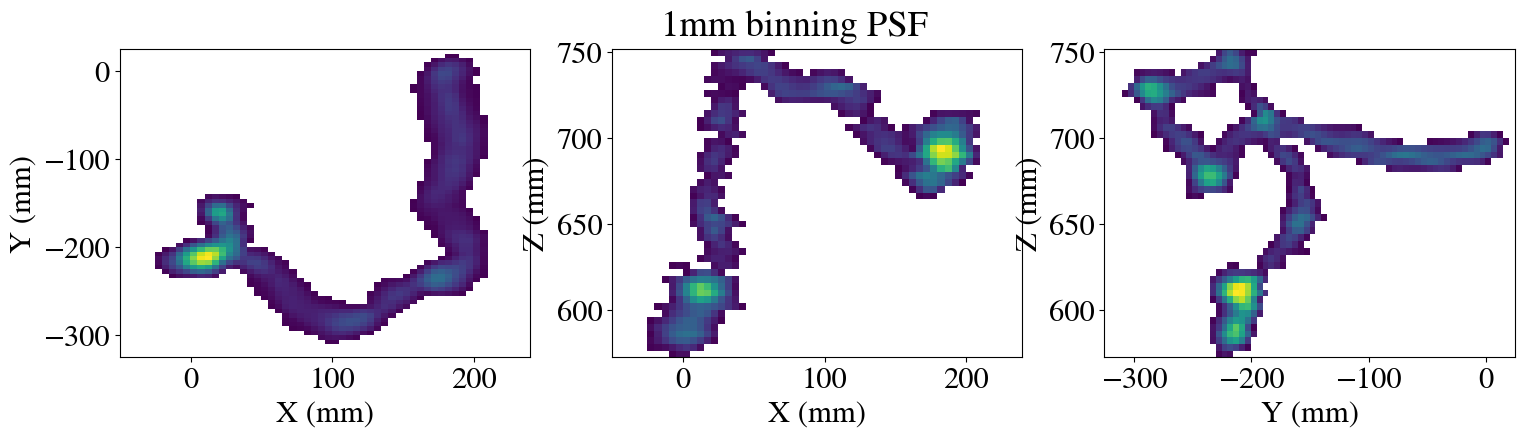

In [10]:
print('====================')
print('1mm deconvolution')
print('====================')
pitch = 15.55
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
hits = hits_drop
xx = np.arange(hits.X.min(), hits.X.max(), 5)
yy = np.arange(hits.Y.min(), hits.Y.max(), 5)

zz = hits.Z.unique()
    
axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('1mm binning PSF')
plt.show(fig)

In [11]:
deconvolver_5mm = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_5mm_)
print(f"{deconv_params_5mm['n_iterations']} iterations")
hits_deco = coref.timefunc(deconvolver_5mm)(hits_drop.copy())


20 iterations
Time spent in apply_deconvolution: 4.107825517654419 s


5mm deconvolution


Text(0.5, 0.98, '5mm binning PSF')

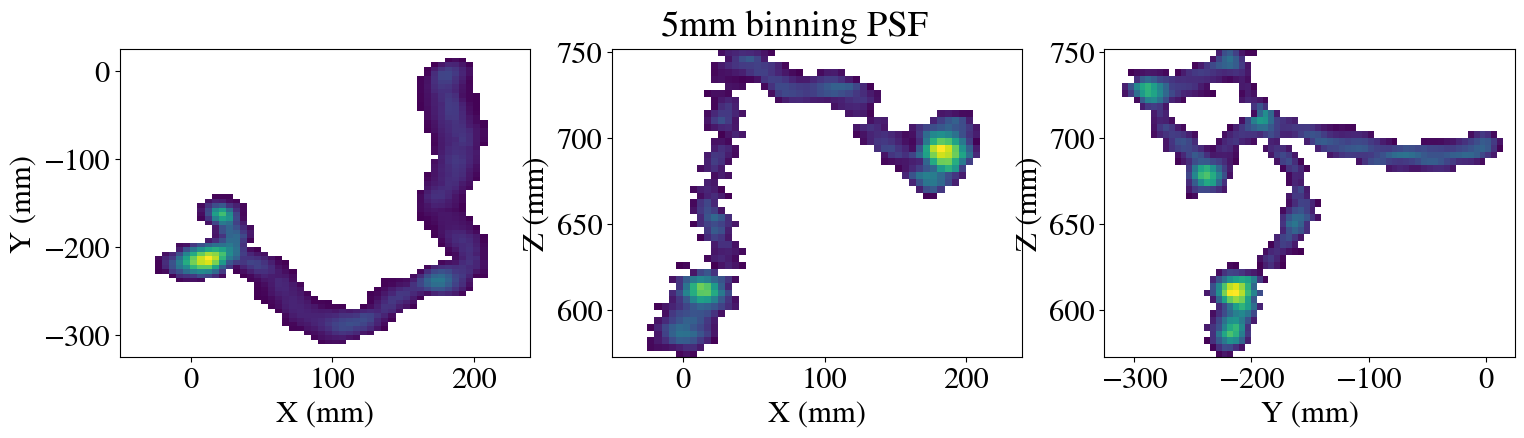

In [12]:
print('====================')
print('5mm deconvolution')
print('====================')
pitch = 15.55
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
hits = hits_drop
xx = np.arange(hits.X.min(), hits.X.max(), 5)
yy = np.arange(hits.Y.min(), hits.Y.max(), 5)

zz = hits.Z.unique()
    
axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('5mm binning PSF')

In [13]:
deconvolver_5DS = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_5DS_)
print(f"{deconv_params_5DS['n_iterations']} iterations")
hits_deco = coref.timefunc(deconvolver_5DS)(hits_drop.copy())


20 iterations
Time spent in apply_deconvolution: 4.402088165283203 s


1mm -> 5mm deconvolution


Text(0.5, 0.98, '5mm -> 1mm binning PSF')

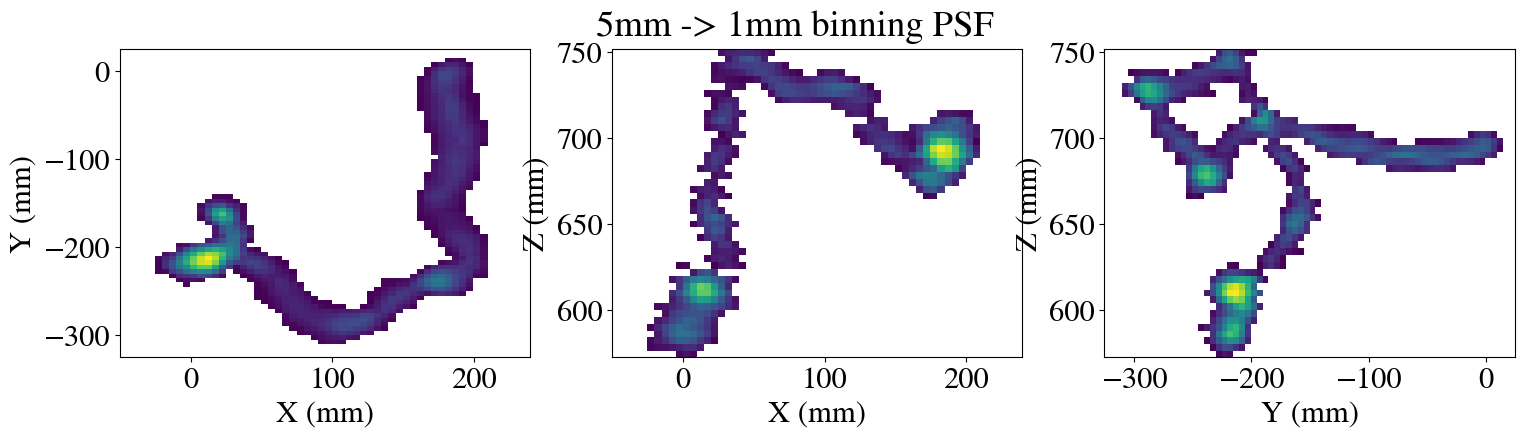

In [14]:
print('====================')
print('1mm -> 5mm deconvolution')
print('====================')
pitch = 15.55
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
hits = hits_drop
xx = np.arange(hits.X.min(), hits.X.max(), 5)
yy = np.arange(hits.Y.min(), hits.Y.max(), 5)

zz = hits.Z.unique()
    
axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('5mm -> 1mm binning PSF')

In [22]:
deconvolver_2DS = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_2DS_)
print(f"{deconv_params_2DS['n_iterations']} iterations")
hits_deco = coref.timefunc(deconvolver_2DS)(hits_drop.copy())

20 iterations
Time spent in apply_deconvolution: 20.88063383102417 s


1mm -> 2.5mm deconvolution


Text(0.5, 0.98, '2.5mm downsampled binning PSF')

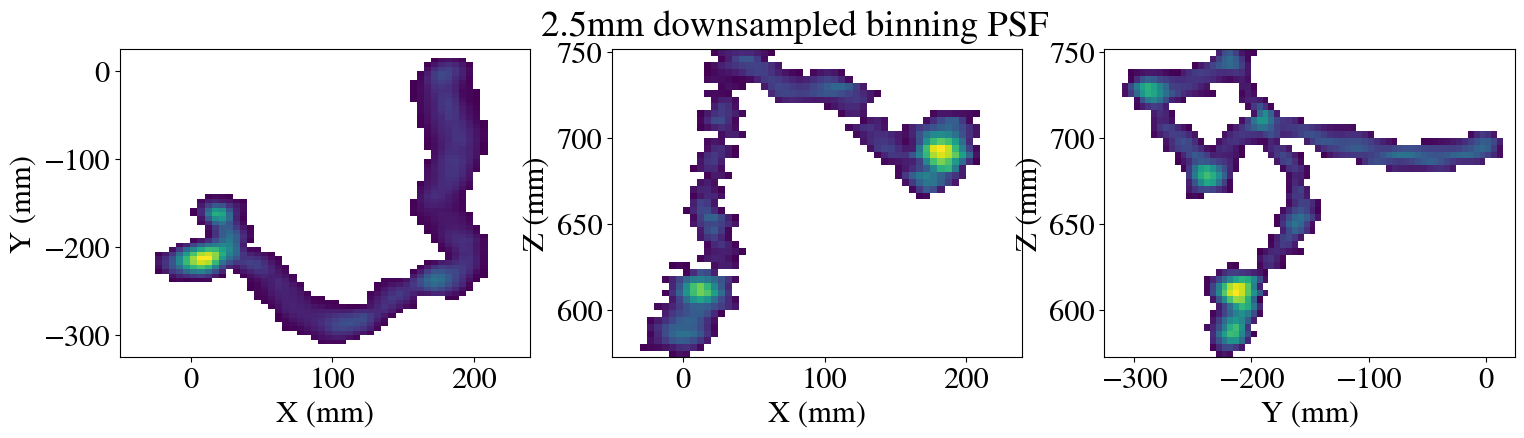

In [24]:
print('====================')
print('1mm -> 2.5mm deconvolution')
print('====================')
pitch = 15.55
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
hits = hits_drop
xx = np.arange(hits.X.min(), hits.X.max(), 5)
yy = np.arange(hits.Y.min(), hits.Y.max(), 5)

zz = hits.Z.unique()
    
axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('2.5mm downsampled binning PSF')